In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
import spacy
from empath import Empath
import scipy.sparse as sp

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/aishwarya/nltk_data...
[nltk_data]   Package words is already up-to-date!


<h2>Data Preparation</h2>

In [216]:
# import first dataset 'data.csv'
df = pd.read_csv("/Users/aishwarya/Desktop/Mini_Project/data.csv");

# inspect shape
print(df.shape)

# inspect columns
print(df.columns)

# inspect first few rows
df.head()

(4009, 4)
Index(['URLs', 'Headline', 'Body', 'Label'], dtype='object')


,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [217]:
# rename labels from 0 to 'REAL' and 1 to 'FAKE'
df.loc[df['Label']== 0, 'Label'] = 'REAL'
df.loc[df['Label']== 1, 'Label'] = 'FAKE'

# drop the column URLs from table
df.drop(['URLs'], axis = 1, inplace = True)
df.head()

,Headline,Body,Label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,FAKE
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",FAKE
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,FAKE
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,FAKE
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",FAKE


In [218]:

# import second dataset 'fake.csv' which contains incorrect news 
df1 = pd.read_csv("/Users/aishwarya/Desktop/Mini_Project/fake.csv");

print(df1.columns)


# print all kinds of incorrect news
print(df1['type'].value_counts())

# select only fake news 
df1 = df1.loc[df1['type']=='fake']
df1.loc[df1['type'] == 'fake', 'type'] = 'FAKE'


# selecting only title, text and type and renaming them
df1 = df1[['title', 'text', 'type']]
df1.columns = ['Headline', 'Body', 'Label']

df1.head()

Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'],
      dtype='object')
bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: type, dtype: int64


,Headline,Body,Label
57,The Amish In America Commit Their Vote To Dona...,18 SHARE The Amish in America have committed t...,FAKE
58,Obama Signs Executive Order Declaring Investig...,64 SHARE President Obama has signed an Executi...,FAKE
379,Comment on HALLOWEEN IN THE CASTRO RETURNS IN ...,"adobochron 10 Comments \nSan Francisco, Califo...",FAKE
380,Comment on Tutorial: Riding The Philippine Jee...,"adobochron 1 Comment \nMANILA, Philippines (Th...",FAKE
381,Comment on What White House Executive Chef Com...,"adobochron 1 Comment Comerford \nWASHINGTON, D...",FAKE


In [219]:
# import third dataset 'fake_or_real_news.csv'
df2 = pd.read_csv("/Users/aishwarya/Desktop/Mini_Project/fake_or_real_news.csv")

df2.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [220]:
# select only columns title, text and label
df2 = df2[['title', 'text', 'label']]

# rename the column names
df2.columns = ['Headline', 'Body', 'Label']

df2.head()

,Headline,Body,Label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [221]:
# importing fourth dataset 'train.csv'
df3 = pd.read_csv("/Users/aishwarya/Desktop/Mini_Project/train.csv")

df3.head()


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [222]:
# select only title, text and label columns
df3 = df3[['title', 'text', 'label']]

# rename the columns
df3.columns = ['Headline', 'Body', 'Label']

# rename the labels names from 0 and 1 to REAL and FAKE
df3.loc[df3['Label'] == 0, 'Label'] = 'REAL'
df3.loc[df3['Label'] == 1, 'Label'] = 'FAKE'

df3.head()

,Headline,Body,Label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,FAKE
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,REAL
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",FAKE
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,FAKE
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,FAKE


In [223]:
# combine all the four datasets
df = df.append(df1, ignore_index = True)
df = df.append(df2, ignore_index = True)
df = df.append(df3, ignore_index = True)

print(df.shape)

df.head()


(31163, 3)


,Headline,Body,Label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,FAKE
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",FAKE
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,FAKE
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,FAKE
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",FAKE


<h2>Data Preprocessing</h2>

In [224]:
# drop any duplicate data points
df = df.drop_duplicates()

print(df.shape)

(28019, 3)


In [225]:
# drop from df if length of the news article is less than 10 
i = 0
ind = []

for article in df['Body']:
    if len(str(article)) < 10:
        ind.append(i)
    i = i + 1
    
df = df.drop(df.index[ind])
print(df.shape)

# drop any null values
df.dropna(inplace=True)

print(df.shape)
        

(27865, 3)
(27356, 3)


In [226]:
# inspect the ratio of labels
df['Label'].value_counts()

REAL    15343
FAKE    12013
Name: Label, dtype: int64

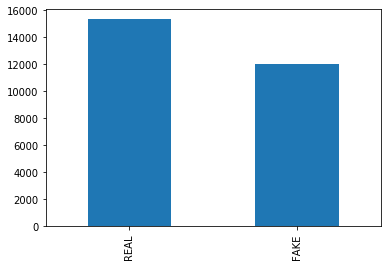

In [227]:
df['Label'].value_counts().plot(kind = 'bar')

In [228]:
# combining Headine and Body 
df['Text'] = df['Headline'] + " " + df['Body']

df.head()


,Headline,Body,Label,Text
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,FAKE,Four ways Bob Corker skewered Donald Trump Ima...
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",FAKE,Linklater's war veteran comedy speaks to moder...
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,FAKE,Trump’s Fight With Corker Jeopardizes His Legi...
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,FAKE,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",FAKE,Jason Aldean opens 'SNL' with Vegas tribute Co...


In [229]:
# Clean text
def clean_text(text):
    # remove punctuation
    text = re.sub('['+string.punctuation+']', '', text)
    text = re.sub(r"[-()\"#/@’;:<>{}`+=~|.!?,]", "", text)
    
    # convert words to lower case and split
    text = text.lower().split()
    
    # remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if w not in stops]
    text = " ".join(text)
    
    # remove all non english and numbers etc.
    text = re.sub(r'[^a-zA-Z\s]', u'', text, flags=re.UNICODE)
    
    # lemmatizing
    text = text.split()
    l = WordNetLemmatizer()
    lemmatized_words = [l.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    
    return text

# apply clean_text on Text column
df['Clean_Text'] = df['Text'].apply(lambda x: clean_text(x))
df.dropna(inplace=True)
    

In [230]:
df.head()

,Headline,Body,Label,Text,Clean_Text
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,FAKE,Four ways Bob Corker skewered Donald Trump Ima...,four way bob corker skewered donald trump imag...
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",FAKE,Linklater's war veteran comedy speaks to moder...,linklaters war veteran comedy speaks modern am...
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,FAKE,Trump’s Fight With Corker Jeopardizes His Legi...,trump fight corker jeopardizes legislative age...
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,FAKE,Egypt's Cheiron wins tie-up with Pemex for Mex...,egypt cheiron win tieup pemex mexican onshore ...
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",FAKE,Jason Aldean opens 'SNL' with Vegas tribute Co...,jason aldean open snl vega tribute country sin...


<h2> Splitting into training and testing sets </h2>

In [231]:
# set y
y = df['Label'].astype('str') 

# Make train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Clean_Text'], y, test_size = 0.33, random_state = 53)

print(X_train.head())
print()
print(y_train.head())


27534    guilt quiz guilt level chart tool guilted age ...
12973    mainstream medium monopoly arrival new medium ...
5240     comment strange fact president tania de saram ...
17740               rt arabic gmt httparrtcomigk rt arabic
1035     odell beckham jr new york giant wide receiver ...
Name: Clean_Text, dtype: object

27534    FAKE
12973    FAKE
5240     FAKE
17740    FAKE
1035     FAKE
Name: Label, dtype: object


<h2>TFIDF Vectorization</h2>

In [232]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2, 2))

tfidf_train = tfidf_vectorizer.fit_transform(X_train)

tfidf_test = tfidf_vectorizer.transform(X_test)

print(tfidf_vectorizer.get_feature_names()[:10])

['aa aa', 'aa armament', 'aa ball', 'aa birmingham', 'aa classmate', 'aa coveted', 'aa division', 'aa fa', 'aa firecontrol', 'aa firepower']


In [233]:
# confusion matrix function definition
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.ylim([1.5, -.5])
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


ACCURACY 0.8264288879042977
Confusion Matrix: 
[[2432 1530]
 [  37 5029]]


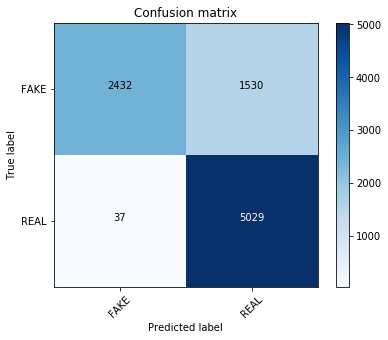

In [234]:
# naive Bayes model for TFIDF bigrams
nb_classifier = MultinomialNB(alpha=0.0)

nb_classifier.fit(tfidf_train, y_train)

pred = nb_classifier.predict(tfidf_test)

# calculate and print accuracy of model
score = metrics.accuracy_score(y_test, pred)
print('ACCURACY', score)

# calculate and print confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print('Confusion Matrix: ')
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])


In [235]:
# improving naive bayes model by testing with different alpha levels

alphas = np.arange(0, 1, 0.1)

# define train_and_predict()
def train_and_predict(alpha):
    # instantiate the classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # fit to training data
    nb_classifier.fit(tfidf_train, y_train)
    # predict the labels
    pred = nb_classifier.predict(tfidf_test)
    # calculate accuracy score
    score = metrics.accuracy_score(y_test, pred)
    return score



# iterate over alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.8264288879042977

Alpha:  0.1
Score:  0.871953921134249

Alpha:  0.2
Score:  0.85279131590607

Alpha:  0.30000000000000004
Score:  0.837948604342047

Alpha:  0.4
Score:  0.8278688524590164

Alpha:  0.5
Score:  0.8206690296854231

Alpha:  0.6000000000000001
Score:  0.8149091714665485

Alpha:  0.7000000000000001
Score:  0.8094816127603013

Alpha:  0.8
Score:  0.8043863535666814

Alpha:  0.9
Score:  0.7997341603898981



/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ACCURACY:  0.8594373061586177
Confusion Matrix: 
[[3478  484]
 [ 785 4281]]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


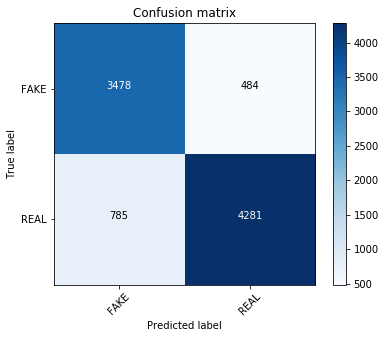

In [236]:
# random forest model for TFIDF bigrams
rf_classifier = RandomForestClassifier(verbose=True)

rf_classifier.fit(tfidf_train, y_train)

pred = rf_classifier.predict(tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print('ACCURACY: ', score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print('Confusion Matrix: ')
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])



      Iter       Train Loss   Remaining Time 
         1           1.3196           13.22m
         2           1.2767           12.59m
         3           1.2402           12.59m
         4           1.2085           12.54m
         5           1.1818           12.43m
         6           1.1591           12.31m
         7           1.1391           12.26m
         8           1.1210           12.14m
         9           1.1047           12.02m
        10           1.0904           11.84m
        20           1.0025            9.99m
        30           0.9610            8.52m
        40           0.9266            7.26m
        50           0.9003            6.03m
        60           0.8760            4.81m
        70           0.8556            3.59m
        80           0.8357            2.40m
        90           0.8179            1.20m
       100           0.8017            0.00s
ACCURACY:  0.8452591936198494
Confusion Matrix: 
[[3642  320]
 [1077 3989]]


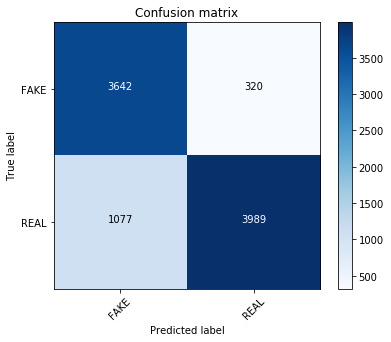

In [237]:
# gradiant Boost model for TFIDF bigrams
gb_classifier = GradientBoostingClassifier(verbose=True)

gb_classifier.fit(tfidf_train, y_train)

pred = gb_classifier.predict(tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print('ACCURACY: ', score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print('Confusion Matrix: ')
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<h2> POS Tagging </h2>

In [238]:
# Generate POS tags 
nlp = spacy.load('en')

pos_tags_column = []

for text in df['Text']:
    pos_tags = []
    doc = nlp(text)
    for token in doc:
        pos_tags.append(token.pos_)
    all_pos_tags = ' '.join(pos_tags)
    pos_tags_column.append(all_pos_tags)
    
df['Text_POS'] = pos_tags_column

df.head()



,Headline,Body,Label,Text,Clean_Text,Text_POS
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,FAKE,Four ways Bob Corker skewered Donald Trump Ima...,four way bob corker skewered donald trump imag...,NUM NOUN PROPN PROPN VERB PROPN PROPN PROPN NO...
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",FAKE,Linklater's war veteran comedy speaks to moder...,linklaters war veteran comedy speaks modern am...,PROPN PART NOUN NOUN NOUN VERB ADP ADJ PROPN P...
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,FAKE,Trump’s Fight With Corker Jeopardizes His Legi...,trump fight corker jeopardizes legislative age...,PROPN PROPN PROPN ADP PROPN PROPN DET ADJ PROP...
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,FAKE,Egypt's Cheiron wins tie-up with Pemex for Mex...,egypt cheiron win tieup pemex mexican onshore ...,PROPN PART PROPN VERB VERB PUNCT NOUN ADP PROP...
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",FAKE,Jason Aldean opens 'SNL' with Vegas tribute Co...,jason aldean open snl vega tribute country sin...,PROPN PROPN VERB PUNCT PROPN PUNCT ADP PROPN N...


In [239]:
# split into training and testing sets using Text_POS 
y = df['Label'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(df['Text_POS'], y, test_size = 0.33, random_state = 53)
print(X_train.head())
print(y_train.head())


27534    PROPN PROPN CCONJ PROPN PROPN PROPN PUNCT NOUN...
12973    DET PROPN PROPN PROPN VERB ADP DET NOUN ADP AD...
5240     NOUN ADP NUM ADJ NOUN ADP DET NOUN ADP NOUN X ...
17740    ADJ NOUN VERB NOUN NOUN NOUN ADP NOUN PUNCT NO...
1035     PROPN PROPN PROPN PUNCT PROPN PROPN PROPN ADJ ...
Name: Text_POS, dtype: object
27534    FAKE
12973    FAKE
5240     FAKE
17740    FAKE
1035     FAKE
Name: Label, dtype: object


In [240]:
# Generating TFIDF bigrams of POS tags
pos_tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2))
pos_tfidf_train = pos_tfidf_vectorizer.fit_transform(X_train.astype('str'))
pos_tfidf_test= pos_tfidf_vectorizer.transform(X_test.astype('str'))
pos_tfidf_vectorizer.get_feature_names()[:10]

['adj adj',
 'adj adp',
 'adj adv',
 'adj aux',
 'adj cconj',
 'adj det',
 'adj intj',
 'adj noun',
 'adj num',
 'adj pron']

Accuracy with Multinomial Naive Bayes: 0.665


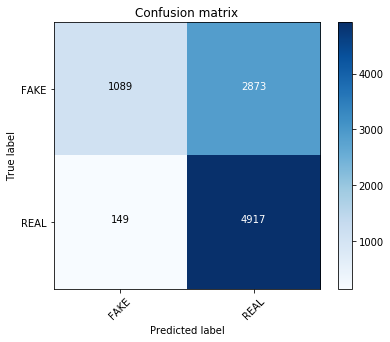

In [241]:
# naive bayes model for POS 
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(pos_tfidf_train, y_train)
pred = nb_classifier.predict(pos_tfidf_test)

#accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes: %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy with RandomForestClassifier:   0.881


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


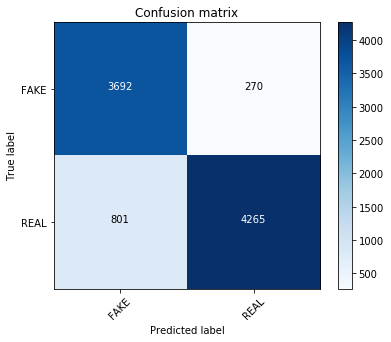

In [242]:
# random forest model for POS
rf_classifier = RandomForestClassifier(verbose=True)
rf_classifier.fit(pos_tfidf_train, y_train)
pred = rf_classifier.predict(pos_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

      Iter       Train Loss   Remaining Time 
         1           1.2900           42.99s
         2           1.2229           41.78s
         3           1.1664           40.95s
         4           1.1189           40.45s
         5           1.0783           40.14s
         6           1.0435           39.65s
         7           1.0130           39.19s
         8           0.9866           38.77s
         9           0.9629           38.32s
        10           0.9409           37.91s
        20           0.8029           33.64s
        30           0.7326           29.38s
        40           0.6853           25.12s
        50           0.6461           20.95s
        60           0.6160           16.81s
        70           0.5858           12.64s
        80           0.5624            8.45s
        90           0.5430            4.24s
       100           0.5247            0.00s
Accuracy with Gradient Boosting:   0.897


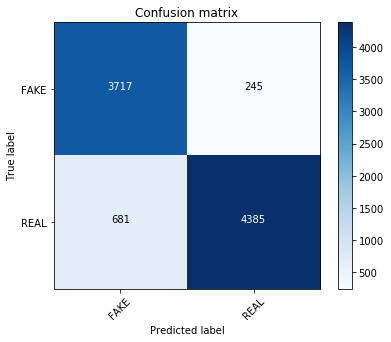

In [243]:
# gradient boost for POS
gb_classifier = GradientBoostingClassifier(verbose=True)
gb_classifier.fit(pos_tfidf_train, y_train)
pred = gb_classifier.predict(pos_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<h2>Semantic Analysis</h2>

In [244]:
# Getting semantic categories scores
lexicon = Empath()
semantic = []
count = 0

for article in df['Text']:
    d = lexicon.analyze(article, normalize=False)
    x = []
    for key, value in d.items():
        x.append(value)
    x = np.asarray(x)
    semantic.append(x)
df['Semantic'] = semantic
print(df['Semantic'].head())

0    [2.0, 6.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, ...
1    [1.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, ...
2    [1.0, 9.0, 1.0, 2.0, 5.0, 3.0, 0.0, 2.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
Name: Semantic, dtype: object


In [245]:
# all categories
categories = []
a = lexicon.analyze("")
for key, value in a.items():
    categories.append(key)
categories

['help',
 'office',
 'dance',
 'money',
 'wedding',
 'domestic_work',
 'sleep',
 'medical_emergency',
 'cold',
 'hate',
 'cheerfulness',
 'aggression',
 'occupation',
 'envy',
 'anticipation',
 'family',
 'vacation',
 'crime',
 'attractive',
 'masculine',
 'prison',
 'health',
 'pride',
 'dispute',
 'nervousness',
 'government',
 'weakness',
 'horror',
 'swearing_terms',
 'leisure',
 'suffering',
 'royalty',
 'wealthy',
 'tourism',
 'furniture',
 'school',
 'magic',
 'beach',
 'journalism',
 'morning',
 'banking',
 'social_media',
 'exercise',
 'night',
 'kill',
 'blue_collar_job',
 'art',
 'ridicule',
 'play',
 'computer',
 'college',
 'optimism',
 'stealing',
 'real_estate',
 'home',
 'divine',
 'sexual',
 'fear',
 'irritability',
 'superhero',
 'business',
 'driving',
 'pet',
 'childish',
 'cooking',
 'exasperation',
 'religion',
 'hipster',
 'internet',
 'surprise',
 'reading',
 'worship',
 'leader',
 'independence',
 'movement',
 'body',
 'noise',
 'eating',
 'medieval',
 'zest',


In [246]:
# Generating semantic classes from semantic score frequency
sem = []
for i in range(df.shape[0]):
    a = []
    for j in range(len(semantic[0])):
        for k in range(int(semantic[i][j])):
            a.append(categories[j])
    b = " ".join(a)
    sem.append(b)
df['Semantics'] = sem

print(df['Semantics'].head())


0    help help office office office office office o...
1    help office office office wedding wedding cold...
2    help office office office office office office...
3    banking play business business sports sports h...
4    cold occupation school art weather music music...
Name: Semantics, dtype: object


In [247]:
# splitting in training and testing sets for Semantic analysis
y = df['Label'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(df['Semantics'], y, test_size = 0.33, random_state = 53)
print(X_train.head())
print(y_train.head())

27534    help help help help help help help help help h...
12973    help money money sleep medical_emergency aggre...
5240     help help office money wedding wedding domesti...
17740                                                     
1035     medical_emergency medical_emergency medical_em...
Name: Semantics, dtype: object
27534    FAKE
12973    FAKE
5240     FAKE
17740    FAKE
1035     FAKE
Name: Label, dtype: object


In [248]:
# Generating TFIDF vectors of the semantic unigrams
sem_tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
sem_tfidf_train = sem_tfidf_vectorizer.fit_transform(X_train.astype('str'))
sem_tfidf_test = sem_tfidf_vectorizer.transform(X_test.astype('str'))


Accuracy with Multinomial Naive Bayes:   0.625


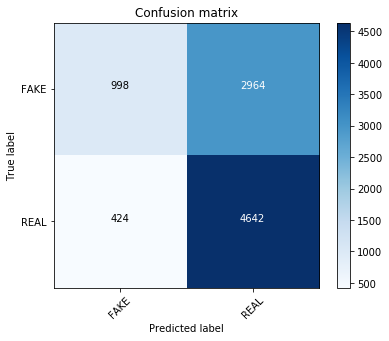

In [249]:
# naive bayes model for semantic analsysis
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(sem_tfidf_train, y_train)
pred = nb_classifier.predict(sem_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy with RandomForestClassifier:   0.670


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


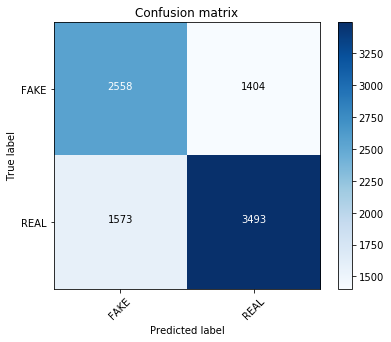

In [250]:
# random forest model for semantic analysis
rf_classifier = RandomForestClassifier(verbose=True)
rf_classifier.fit(sem_tfidf_train, y_train)
pred = rf_classifier.predict(sem_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

# confusion matrix 
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

      Iter       Train Loss   Remaining Time 
         1           1.3564           36.96s
         2           1.3436           36.53s
         3           1.3328           35.74s
         4           1.3229           35.33s
         5           1.3142           34.84s
         6           1.3063           34.32s
         7           1.2981           33.81s
         8           1.2916           33.52s
         9           1.2847           33.04s
        10           1.2783           32.54s
        20           1.2326           28.97s
        30           1.2029           25.21s
        40           1.1794           21.62s
        50           1.1606           18.02s
        60           1.1437           14.43s
        70           1.1290           10.84s
        80           1.1157            7.24s
        90           1.1039            3.63s
       100           1.0931            0.00s
Accuracy with Gradient Boosting:   0.694


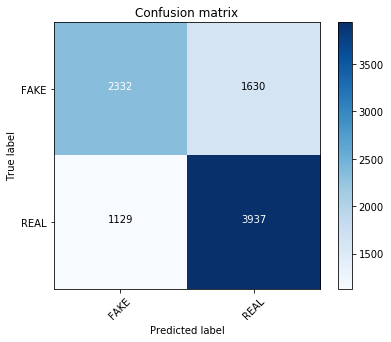

In [251]:
# gradient boosting model for semantic analysis
gb_classifier = GradientBoostingClassifier(verbose=True)
gb_classifier.fit(sem_tfidf_train, y_train)
pred = gb_classifier.predict(sem_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

# confusion matrix 
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<h2>Combining the 3 features - TFIDF, POS and Semantic </h2>

In [252]:
print(df.columns)
print(df.shape)

# drop label from df to create X
X = df.drop('Label', axis = 1)

print(X.columns)

Index(['Headline', 'Body', 'Label', 'Text', 'Clean_Text', 'Text_POS',
       'Semantic', 'Semantics'],
      dtype='object')
(27356, 8)
Index(['Headline', 'Body', 'Text', 'Clean_Text', 'Text_POS', 'Semantic',
       'Semantics'],
      dtype='object')


In [253]:
# take Label as y
y = df.Label

# split into training and testing sets using X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 53)


In [254]:
X_train_text = X_train['Clean_Text']
X_test_text = X_test['Clean_Text']

X_train_POS = X_train['Text_POS']
X_test_POS = X_test['Text_POS']

X_train_sem = X_train['Semantics']
X_test_sem = X_test['Semantics']

In [255]:
# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,3), max_features=20000)
tfidf_train = tfidf_vectorizer.fit_transform(X_train_text.astype('str'))
tfidf_test = tfidf_vectorizer.transform(X_test_text.astype('str'))


In [256]:
# POS TFIDF Vectorizer
pos_tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,3), max_features=20000)
pos_tfidf_train = pos_tfidf_vectorizer.fit_transform(X_train_POS.astype('str'))
pos_tfidf_test = pos_tfidf_vectorizer.transform(X_test_POS.astype('str'))

In [257]:
# Semantic TFIDF Vectorizer
sem_tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_features=20000)
sem_tfidf_train = sem_tfidf_vectorizer.fit_transform(X_train_sem.astype('str'))
sem_tfidf_test = sem_tfidf_vectorizer.transform(X_test_sem.astype('str'))

In [258]:
# setting weights for each feature vector
text_w = 0.35 * 3
pos_w = 0.5 * 3
sem_w = 0.15 * 3

tfidf_train *= text_w
tfidf_test *= text_w
pos_tfidf_train *= pos_w
pos_tfidf_test *= pos_w
sem_tfidf_train *= sem_w
sem_tfidf_train *= sem_w

In [259]:
# Combining the 3 sparse matrices to form X_train and X_test
# vstack - vertical 
# hstack - horizontal
# they are used to combine arrays and make them into one array
diff_n_rows = pos_tfidf_train.shape[0] - tfidf_train.shape[0]
b = sp.vstack((tfidf_train, sp.csr_matrix((diff_n_rows, tfidf_train.shape[1]))))
c = sp.hstack((pos_tfidf_train, b))

diff_n_rows = c.shape[0] - sem_tfidf_train.shape[0]
b = sp.vstack((sem_tfidf_train, sp.csr_matrix((diff_n_rows, sem_tfidf_train.shape[1]))))

# X - train
X_train = sp.hstack((c, b))

diff_n_rows = pos_tfidf_test.shape[0] - tfidf_test.shape[0]
d = sp.vstack((tfidf_test, sp.csr_matrix((diff_n_rows, tfidf_test.shape[1]))))
e = sp.hstack((pos_tfidf_test, d))

diff_n_rows = e.shape[0] - sem_tfidf_test.shape[0]
d = sp.vstack((sem_tfidf_test, sp.csr_matrix((diff_n_rows, sem_tfidf_test.shape[1]))))

# Y - test
X_test = sp.hstack((e, d))


Accuracy with Multinomial Naive Bayes:   0.916


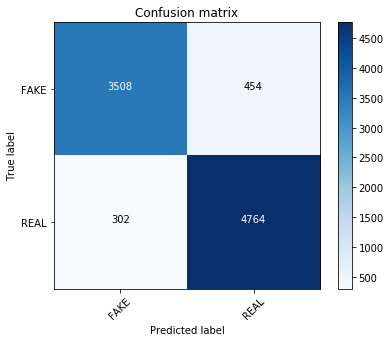

In [260]:
# naive bayes model
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(X_train, y_train)
pred = nb_classifier.predict(X_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy:  0.893


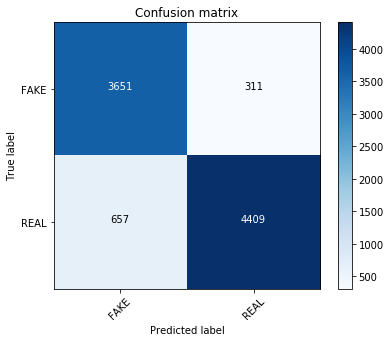

In [262]:
# random forest model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
pred = rf_classifier.predict(X_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy:  %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

      Iter       Train Loss   Remaining Time 
         1           1.2861            5.87m
         2           1.2156            5.54m
         3           1.1558            5.40m
         4           1.1048            5.22m
         5           1.0603            5.09m
         6           1.0217            4.99m
         7           0.9874            4.91m
         8           0.9487            4.85m
         9           0.9216            4.80m
        10           0.8967            4.78m
        20           0.7208            4.28m
        30           0.6212            3.72m
        40           0.5590            3.15m
        50           0.5149            2.60m
        60           0.4774            2.07m
        70           0.4505            1.55m
        80           0.4258            1.03m
        90           0.4045           30.77s
       100           0.3860            0.00s
Accuracy:   0.937


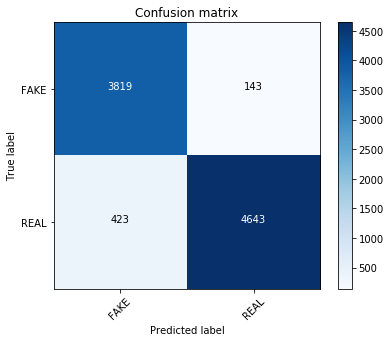

In [263]:
# gradient boost model
gb_classifier = GradientBoostingClassifier(verbose=True)
gb_classifier.fit(X_train, y_train)
pred = gb_classifier.predict(X_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<h2>Predicting for new data...</h2>

In [264]:
# Take input from user for new data point prediction
new_data = pd.DataFrame()

headline = input("Enter the headline of article: \n")
body = input("Enter the body of article: \n")

new_data['Headline'] = [headline]
new_data['Body'] = [body]

# combine headline and body into text
new_data['Text'] = new_data['Headline'] + new_data['Body']

# apply clean_text on new data point
new_data['Clean_Text'] = new_data['Text'].apply(lambda x: clean_text(x))
new_data.head()


Enter the headline of article: 
10 Ways America Is Preparing for World War 3
Enter the body of article: 
October 31, 2016 at 4:52 am  Pretty factual except for women in the selective service. American military is still voluntary only and hasn't been a draft since Vietnam war. The comment was made by a 4 star general of the army about drafting women and he said it to shut up liberal yahoos.﻿


,Headline,Body,Text,Clean_Text
0,10 Ways America Is Preparing for World War 3,"October 31, 2016 at 4:52 am Pretty factual ex...",10 Ways America Is Preparing for World War 3Oc...,way america preparing world war october pretty...


In [265]:
# transform using TFIDF vectorizier
tfidf = tfidf_vectorizer.transform(new_data['Clean_Text'])

In [266]:
# generate POS tags for new data point
pos_tags_column = []
pos_tags = []
doc = nlp(new_data['Text'][0])
for token in doc:
    pos_tags.append(token.pos_)
all_pos_tags = ' '.join(pos_tags)
pos_tags_column.append(all_pos_tags)

new_data['Text_POS'] = pos_tags_column
new_data.head()


,Headline,Body,Text,Clean_Text,Text_POS
0,10 Ways America Is Preparing for World War 3,"October 31, 2016 at 4:52 am Pretty factual ex...",10 Ways America Is Preparing for World War 3Oc...,way america preparing world war october pretty...,NUM PROPN PROPN VERB VERB ADP PROPN PROPN NUM ...


In [267]:
# transform using TFIDF POS vectorizer
pos_tfidf = pos_tfidf_vectorizer.transform(new_data['Text_POS'])


In [268]:
# generate semantic scores for new data point
semantic = []


d = lexicon.analyze(new_data['Text'][0], normalize=False)
x = []
for key, value in d.items():
    x.append(value)
    
x = np.asarray(x)
semantic.append(x)

new_data['Semantic'] = semantic
new_data['Semantic'].head()


0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Semantic, dtype: object

In [269]:
categories = []
a = lexicon.analyze("")
for key, value in a.items():
    categories.append(key)
categories

['help',
 'office',
 'dance',
 'money',
 'wedding',
 'domestic_work',
 'sleep',
 'medical_emergency',
 'cold',
 'hate',
 'cheerfulness',
 'aggression',
 'occupation',
 'envy',
 'anticipation',
 'family',
 'vacation',
 'crime',
 'attractive',
 'masculine',
 'prison',
 'health',
 'pride',
 'dispute',
 'nervousness',
 'government',
 'weakness',
 'horror',
 'swearing_terms',
 'leisure',
 'suffering',
 'royalty',
 'wealthy',
 'tourism',
 'furniture',
 'school',
 'magic',
 'beach',
 'journalism',
 'morning',
 'banking',
 'social_media',
 'exercise',
 'night',
 'kill',
 'blue_collar_job',
 'art',
 'ridicule',
 'play',
 'computer',
 'college',
 'optimism',
 'stealing',
 'real_estate',
 'home',
 'divine',
 'sexual',
 'fear',
 'irritability',
 'superhero',
 'business',
 'driving',
 'pet',
 'childish',
 'cooking',
 'exasperation',
 'religion',
 'hipster',
 'internet',
 'surprise',
 'reading',
 'worship',
 'leader',
 'independence',
 'movement',
 'body',
 'noise',
 'eating',
 'medieval',
 'zest',


In [270]:
# generate semantic categories for new data point
sem = []
for i in range(new_data.shape[0]):
    a = []
    for j in range(len(semantic[0])):
        for k in range(int(semantic[i][j])):
            a.append(categories[j])
    b = ' '.join(a)
    sem.append(b)
new_data['Semantics'] = sem

print(new_data['Semantics'].head())

0    social_media night reading leader legend domin...
Name: Semantics, dtype: object


In [271]:
new_data.head()

,Headline,Body,Text,Clean_Text,Text_POS,Semantic,Semantics
0,10 Ways America Is Preparing for World War 3,"October 31, 2016 at 4:52 am Pretty factual ex...",10 Ways America Is Preparing for World War 3Oc...,way america preparing world war october pretty...,NUM PROPN PROPN VERB VERB ADP PROPN PROPN NUM ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",social_media night reading leader legend domin...


In [272]:
# transform using TFIDF semantic vectorizer
sem_tfidf = sem_tfidf_vectorizer.transform(new_data['Semantics'].astype('str'))

In [273]:
# Combine all 3 sparse matrices to form test data point
diff_n_rows = pos_tfidf.shape[0] - tfidf.shape[0]
b = sp.vstack((tfidf, sp.csr_matrix((diff_n_rows, tfidf.shape[1]))))
c = sp.hstack((pos_tfidf, b))

diff_n_rows = c.shape[0] - sem_tfidf.shape[0]
b = sp.vstack((sem_tfidf, sp.csr_matrix((diff_n_rows, sem_tfidf.shape[1]))))
X = sp.hstack((c, b))

<h3>Result</h3>

In [274]:
# prediction
pred = gb_classifier.predict(X)
print(pred)

# probalitistic prediction 
print(gb_classifier.predict_proba(Y))

['FAKE']
[[0.85473741 0.14526259]]
